#UV treated Silk pattern decomposition

This notebook shows how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff for his own vacation purposes



Setup, Import Code

In [2]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import sys
sys.path.append("../")
import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file


In [4]:
rawData_df = pd.read_csv(r"C:\Users\jrosh\FTIRpythonAttempt\FTIRrawspectraUVmaskLeftside.csv", header=None) 
# rawData_df.rename(columns={0: "wavenumber", 1: "1,1", 2:"1,2"}, inplace=True)
# len(rawData_df)
# # for x in rawData_df:
# #     rawData_df.rename(columns={0: "wavenumber", 1:"1,1", 2:"1,2"}, inplace=True)

# sample_names = list(rawData_df.columns)[1:]
# rawData_df[(rawData_df['wavenumber'] > 1450) & (rawData_df['wavenumber'] < 1820)].plot.line(x='wavenumber', y='1,1').invert_xaxis()
# #can I plot multiple spectra and label them?
# rawData_df[(rawData_df['wavenumber'] > 1450) & (rawData_df['wavenumber'] < 1820)].plot.line(x='wavenumber', y=['1,1','1,2']).invert_xaxis()

In [5]:
# imports
%matplotlib inline
import os
import pandas as pd
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990
from ftir.io.utils import create_df_from_single_file

# get the data
#mydata= pd.read_csv("C:\\Users\\Deepanshu\\Documents\\file1.csv")

#os.getcwd()
#raw_data_filename = os.path.abspath("./20191009_nsm_Icatibant/2Der/23_0 2Der.txt")
# rawData_df = pd.read_csv("C:\Users\jrosh\FTIRpythonAttempt\FTIRrawspectraUVmaskLeftside.csv") #pd.read_csv(raw_data_filename, header=None)
#rawData_df.rename(columns={0: "Wavenumber", 1: "first_point"}, inplace=True)
#sample_names = list(rawData_df.columns)[1:]
#rawData_df[(rawData_df['Wavenumber'] > 1450) & (rawData_df['Wavenumber'] < 1820)].plot.line(x='Wavenumber', y='first_point').invert_xaxis()

In [6]:
rawData_df.shape

(2381, 626)

In [16]:
#dim1 = np.array([1:1:25])
dims = []
for i in range(1,626):
    dims.append(f"cols{i}")
    # for j in range(1,26):
    #     dims.append(str([i,j]))


In [17]:
len(dims)

625

In [18]:

column_names = list(['wavenumber'])+ dims


In [19]:
type(column_names[3])

str

In [21]:
beta_sheet_df = pd.DataFrame(rawData_df.values, columns = column_names)

In [22]:
beta_sheet_df.head()

,wavenumber,cols1,cols2,cols3,cols4,cols5,cols6,cols7,cols8,cols9,...,cols616,cols617,cols618,cols619,cols620,cols621,cols622,cols623,cols624,cols625
0,3998.51641,-0.06644,-0.04270,-0.06485,-0.04348,-0.06823,-0.04454,-0.04577,-0.06635,-0.04624,...,-0.05422,-0.01904,-0.04217,-0.04848,-0.05179,-0.05199,-0.04612,-0.04532,-0.04466,-0.04514
1,3997.08837,-0.06644,-0.04254,-0.06487,-0.04346,-0.06814,-0.04452,-0.04576,-0.06635,-0.04620,...,-0.05433,-0.01921,-0.04232,-0.04859,-0.05191,-0.05213,-0.04629,-0.04548,-0.04480,-0.04520
2,3995.66033,-0.06643,-0.04252,-0.06487,-0.04347,-0.06807,-0.04454,-0.04578,-0.06637,-0.04621,...,-0.05446,-0.01938,-0.04245,-0.04873,-0.05204,-0.05225,-0.04648,-0.04569,-0.04497,-0.04534
3,3994.23229,-0.06643,-0.04265,-0.06489,-0.04351,-0.06807,-0.04460,-0.04580,-0.06640,-0.04627,...,-0.05458,-0.01951,-0.04251,-0.04885,-0.05216,-0.05236,-0.04664,-0.04586,-0.04512,-0.04552
4,3992.80425,-0.06642,-0.04281,-0.06494,-0.04356,-0.06815,-0.04467,-0.04584,-0.06645,-0.04634,...,-0.05466,-0.01964,-0.04253,-0.04895,-0.05226,-0.05247,-0.04680,-0.04595,-0.04523,-0.04570


## Baseline correction

Rubberband baseline correction was done, and the spectra was flipped over the y-axis. The spectra was also narrowed to focus only on the amide I region.

In [36]:
# imports
%matplotlib inline
import os
import pandas as pd
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990
from ftir.io.utils import create_df_from_single_file

# get the data
#mydata= pd.read_csv("C:\\Users\\Deepanshu\\Documents\\file1.csv")

# #os.getcwd()
# #raw_data_filename = os.path.abspath("./20191009_nsm_Icatibant/2Der/23_0 2Der.txt")
# rawData_df = pd.read_csv("C:\Users\jrosh\FTIRpythonAttempt\FTIRrawspectraUVmaskLeftside.csv") #pd.read_csv(raw_data_filename, header=None)
# rawData_df.rename(columns={0: "Wavenumber", 1: "first_point"}, inplace=True)
# sample_names = list(rawData_df.columns)[1:]
# rawData_df[(rawData_df['Wavenumber'] > 1450) & (rawData_df['Wavenumber'] < 1820)].plot.line(x='Wavenumber', y='first_point').invert_xaxis()

In [41]:
corrected_beta_sheet = []
for cols_ in beta_sheet_df.columns[1:]:
    #print(str(cols_))
    corrected_beta_sheet.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1725, 1595)))

In [45]:
corrected_beta_sheet

[    wavenumber     cols1
 0   1723.64618  0.000000
 1   1722.21814  0.000020
 2   1720.79010  0.000030
 3   1719.36206  0.000000
 4   1717.93402  0.000000
 ..         ...       ...
 86  1600.83461  0.019115
 87  1599.40657  0.013413
 88  1597.97852  0.008582
 89  1596.55048  0.004181
 90  1595.12244  0.000000
 
 [91 rows x 2 columns],
     wavenumber     cols2
 0   1723.64618  0.000000
 1   1722.21814  0.000003
 2   1720.79010  0.000017
 3   1719.36206  0.000000
 4   1717.93402  0.000000
 ..         ...       ...
 86  1600.83461  0.019053
 87  1599.40657  0.013347
 88  1597.97852  0.008522
 89  1596.55048  0.004156
 90  1595.12244  0.000000
 
 [91 rows x 2 columns],
     wavenumber     cols3
 0   1723.64618  0.000000
 1   1722.21814  0.000027
 2   1720.79010  0.000043
 3   1719.36206  0.000000
 4   1717.93402  0.000000
 ..         ...       ...
 86  1600.83461  0.018970
 87  1599.40657  0.013325
 88  1597.97852  0.008550
 89  1596.55048  0.004185
 90  1595.12244  0.000000
 
 [91 rows 

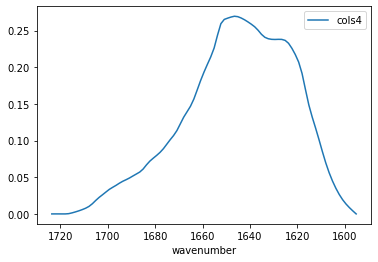

In [56]:
#corrected_df = sd_baseline_correction(beta_sheet_df, cols=['cols1'], flip=False, method='rubberband', bounds=(1725, 1595))
corrected_beta_sheet[3].plot.line(x='wavenumber', y=corrected_beta_sheet[3].columns[1]).invert_xaxis()

In [58]:
#this is in peak_fitting but I'm putting it here too because Ritwika did
import math
#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
#this below doesn't work!!!
#from ftir.modeling.peak_definitions import hu_Kaplan_Cebe_2006_actual
hu_Kaplan_Cebe_2006_rounded = {
    'means': [1610, 1619, 1625, 1633,  1642, 1650, 1659, 1667, 1679, 1692, 1700],
    'uncertainties': [(1605, 1615), (1616, 1621), (1622, 1627), (1628, 1637),
                      (1638, 1646), (1647, 1655), (1656, 1662), (1663, 1670),
                      (1671, 1685), (1686, 1696), (1697, 1703)],
    'relative_uncertainties': [5, 2.5, 2.5, 4.5, 4, 4, 3, 3.5, 7, 5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet(weak)', 
                    'intermolecular beta_sheet (strong)', 'intramolecular beta_sheet (strong)^b',
                    'random coils/extended', 'random coils', 'alpha-helices', 'turns',
                    'turns', 'turns', 'intermolecular beta_sheets (weak)']
}

six_peak = {
    'means': [1610, 1625,  1646, 1659, 1679, 1700],
    'uncertainties': [(1605, 1615), (1616, 1637),
                      (1638, 1646), (1647, 1662), (1663, 1696), (1697, 1703)],
    'relative_uncertainties': [5, 10.5, 4, 7.5, 16.5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet',
                    'random coils', 'alpha-helices', 'turns', 'intermolecular beta_sheets (weak)']
}


from scipy import optimize
from scipy.spatial import ConvexHull

def gaussian_least_squares_(df, col, peaks= six_peak,
                           peak_width=15, params=dict()): # originally was yang_h20_2015,

    def fun(p, x, y):
        """ Minimizing across parameter space p, for a given range, x"""
        return gaussian_sum(x, *p) - y

    data = np.array(pd.concat([df.iloc[:,0], df[col]], axis=1))
    heights = guess_heights_(df, col, peaks['means'], gain=1.0)
    width = peak_width
    lb = list()
    ub = list()
    guess = list()

    # Make 1-D array for optimization func definition above
    for mean, bound, height in zip(peaks['means'], peaks['uncertainties'],
                                   heights):
        lb.extend([0, bound[0], 0])
        ubh = np.inf if height <= 0 else height
        ub.extend([ubh, bound[1], peak_width*1])
        guess.extend([height*0.95, mean, peak_width])

    args = [fun, np.array(guess)]
    params['args'] = (data[:, 0], data[:, 1])
    params['bounds'] = (np.array(lb), np.array(ub))
    res = optimize.least_squares(*args, **params)

    areas = list()
    for i in range(0, len(res.x), 3):
        height = res.x[i]
        width = res.x[i+2]
        area = gaussian_integral(height, width)
        areas.append(area)
    return areas, res

def guess_heights_(df, col, center_list, gain=0.95):
    """ Determines guesses for the heights based on measured data.

    Function creates an integer mapping to the measured frequencies, and then
    creates an initial peak height guess of gain*actual height at x=freq*. A
    Default of 0.95 seems to work best for most spectra, but can be change to
    improve convergence.

    Parameters
    ----------
    df : Dataframe
        Dataframe containing the measured absorbance data

    col : string or integer
        Column index for the absorbance data being fit. Accepts either index
        or string convention.

    center_list : iterable of integers
        An iterable of integer peak positions used to find the experiment
        absorbance at a given wavenumber. I.e, the heights are returned at the
        center values in this iterable

    gain : number (optional)
        Fraction of the measured absorbance value to use determine the initial
        guess for the peak height. The value Default value is 0.95, and thus
        by default, all initial peak guesses are 95% of the peak max.

    """
    heights = []
    freq_map = {}
    for i in df.iloc[:,0]:
        j = math.floor(i)
        freq_map[j] = float(df[col].get(df.iloc[:,0] == i))
    print(freq_map)
    # pdb.set_trace()
    for i in center_list:
        height = freq_map[i]
        heights.append(gain*height)
    return heights



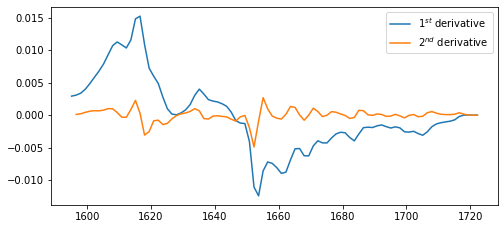

In [59]:
# find_deriv(dfcorrected_df, flip, window_length=5)
# deriv_df.plot(kind='line',x=deriv_df.columns[0],y=deriv_df.columns[1:], figsize=(15,10))

In [67]:
corrected_beta_sheet[0].columns[1]

'cols1'

In [72]:
len(corrected_beta_sheet)

625

In [80]:
structs =[]
gaussian_data = []
for i in range(0,len(corrected_beta_sheet)):
    
    sample = corrected_beta_sheet[i].columns[1]
    #print("Analyzing {}".format(corrected_df[i].columns[1]))
    area, res = gaussian_least_squares(corrected_beta_sheet[i], corrected_beta_sheet[i].columns[1], peak_width=15, 
                                    peaks=six_peak, params={'loss':'linear'})
    structs.append(secondary_structure(area, six_peak))
    gaussian_list_data = gaussian_list(corrected_beta_sheet[i]['wavenumber'], *res.x)
    gaussian_data.append(gaussian_list_data)
    #plt = create_fit_plots(corrected_df[i], sample, gaussian_list_data)
    #plt.show()

#print(structs[0])

In [82]:
len(structs)

625

Analyzing 1,1


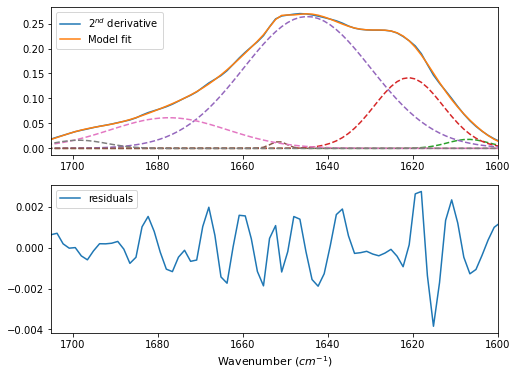

{'alpha-helices': 0.0041803022305271316, 'intermolecular beta_sheets (weak)': 0.01722433611956705, 'random coils': 0.6427984668698427, 'aggregate beta-strand/beta_sheet': 0.18454599334950716, '(Tyr) side chains/aggregate strands': 0.014400780509805172, 'turns': 0.13685012092075066}


In [26]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=15, 
                                   peaks=six_peak, params={'loss':'linear'})
structs = secondary_structure(area, six_peak)
gaussian_list_data = gaussian_list(corrected_df['wavenumber'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)

Attempt to copmpare area of beta sheet vs random coils out 

In [91]:
ratio_1 = []
ratio_2 = []
for i in range(0,len(structs)):
    ratio_1.append(structs[i]['aggregate beta-strand/beta_sheet'] + structs[i]['intermolecular beta_sheets (weak)'])
    #ratio_2.append(structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])/(structs[i]['alpha-helices']+structs[i]['random coils']+structs[i]['turns']+structs[i]['(Tyr) side chains/aggregate strands']+structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])


In [92]:
len(ratio_1)

625

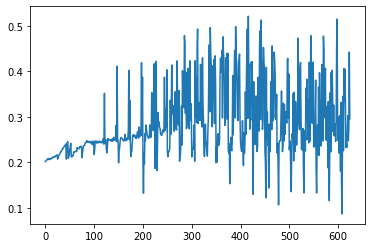

In [95]:
plt.plot(ratio_1)

In [36]:
(structs['aggregate beta-strand/beta_sheet']+structs['intermolecular beta_sheets (weak)']) # ANSWER FOR ONE COLUMN NEEDED FOR ALL

0.20177032946907422

In [38]:
structs['random coils']

0.6427984668698427

In [96]:
import seaborn as sns

In [133]:
break_ratio_1 = np.array_split(np.array(ratio_1),25)

In [153]:
break_ratio_1[0:2]

[array([0.20177033, 0.20380595, 0.20436157, 0.20533151, 0.20725578,
        0.20853593, 0.20859538, 0.20623563, 0.20762283, 0.20635367,
        0.20843614, 0.20707387, 0.20914503, 0.21002413, 0.20940725,
        0.21147943, 0.21087718, 0.21206943, 0.21252851, 0.21140226,
        0.21331635, 0.21480223, 0.21536028, 0.21528078, 0.21688354]),
 array([0.2072607 , 0.21086003, 0.21344617, 0.21641422, 0.21757325,
        0.2206121 , 0.22325007, 0.2232637 , 0.22554751, 0.22785494,
        0.23009904, 0.23017514, 0.23316491, 0.23432509, 0.23624481,
        0.2376754 , 0.23754104, 0.24048927, 0.20741624, 0.24101659,
        0.24454548, 0.24558569, 0.20927553, 0.21354125, 0.21729583])]

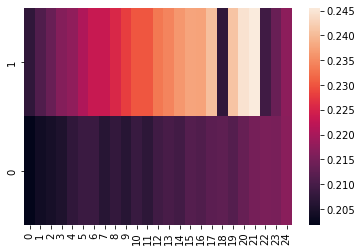

In [152]:
ax_example = sns.heatmap(break_ratio_1[0:2])

ax_example.invert_yaxis()

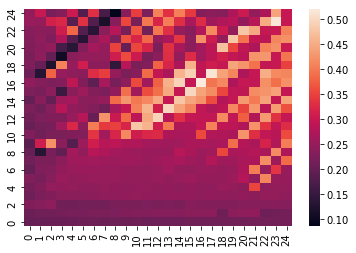

In [139]:
ax = sns.heatmap(break_ratio_1)
ax.invert_yaxis()

In [115]:
ratio_subsection = [ratio_1[0:25], ratio_1[25:50]]

<AxesSubplot:>

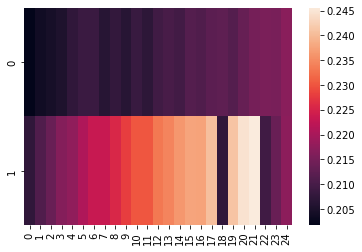

In [119]:
sns.heatmap(ratio_subsection)

In [ ]:
sns.heat

In [114]:
pd.DataFrame(ratio_1[1:25]).corr()

,0
0,1.0


## Peak fitting results


In [ ]:
from copy import deepcopy
new_peaks = deepcopy(yang_h20_2015)
new_peaks['means'].append(1610)
new_peaks['assignments'].append('side-chain')
new_peaks['uncertainties'].append((1606, 1616))
new_peaks['relative_uncertainties'].append(4)

In [ ]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=1.5, peaks=new_peaks)
structs = secondary_structure(area, new_peaks)
gaussian_list_data = gaussian_list(corrected_df['freq'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)

In [ ]:
###SKIPPING bc derivative not needed


#2nd derivative data from original spectra
#need to figure out how the indexing works as taking differences means we lose one value in the x-dimension (wavenumber) here
corrected_df['wavenumber']
corrected_df_1stDerivative = np.diff(corrected_df['1,1'])/np.diff(corrected_df['wavenumber'])
corrected_df_2ndDerivative = np.diff(corrected_df_1stDerivative)/np.diff(corrected_df['wavenumber'][0:90])

#corrected_df_2ndDerivative = np.diff(corrected_df, 2)
#print(corrected_df_2ndDerivative)
# #print(corrected_df_1stDerivative)
# print(corrected_df_1stDerivative)
# print(corrected_df_2ndDerivative)
# type(corrected_df_1stDerivative)
#corrected_df['wavenumber']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211)
ax.plot(corrected_df['wavenumber'][1:91], corrected_df_1stDerivative, label='$1^{st}$ derivative')
ax.plot(corrected_df['wavenumber'][1:90], corrected_df_2ndDerivative, label='$2^{nd}$ derivative')
ax.legend(loc=1)




#
# # corrected_df_2ndDerivative = corrected_df.derivative(n=2)
# from scipy.interpolate import UnivariateSpline

# y_spl = UnivariateSpline(x,y,s=0,k=4)
# #plt.plot(x_range,y_spl_2d(x_range))